In [1]:
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display
from sklearn.linear_model import LogisticRegression

from tools import Modelisation, columns_cat, columns_quant, datasets

t = time.time()

In [2]:
df = pd.read_csv('data/df_train_prepro.csv').sample(frac=1)
df.shape

(1610494, 48)

**Définition des variables quantitatives, des variables catégorielles et des datasets :**

In [3]:
print("Columns_quant :")
display(columns_quant)
print("\nColumns_cat :")
display(columns_cat)

X_quant, X_quant_scaled, X_cat, X_cat_scaled, X_quant_cat, X_quant_cat_scaled, y = datasets(df)

Columns_quant :


['contextid',
 'campaignctrlast24h',
 'dayssincelastvisitdouble',
 'ltf_nbglobaldisplay_4w',
 'ltf_nbpartnerdisplayssincelastclick',
 'ltf_nbpartnerdisplay_90d',
 'ltf_nbpartnerclick_90d',
 'ltf_nbpartnersales_90d',
 'nbdayssincelastclick',
 'nbdisplay_1hour',
 'nbdisplayglobalapprox_1d_sum_xdevice',
 'display_size',
 'zonecostineuro']


Columns_cat :


['display_env',
 'target_env',
 'campaignscenario',
 'campaignvertical',
 'is_interstitial',
 'device_type',
 'hour',
 'weekday']


Nombre de variables pour X_quant : 13



Index(['contextid', 'campaignctrlast24h', 'dayssincelastvisitdouble',
       'ltf_nbglobaldisplay_4w', 'ltf_nbpartnerdisplayssincelastclick',
       'ltf_nbpartnerdisplay_90d', 'ltf_nbpartnerclick_90d',
       'ltf_nbpartnersales_90d', 'nbdayssincelastclick', 'nbdisplay_1hour',
       'nbdisplayglobalapprox_1d_sum_xdevice', 'display_size',
       'zonecostineuro'],
      dtype='object')


Nombre de variables pour X_cat : 50



Index(['display_env_app_ios', 'display_env_other', 'display_env_web',
       'target_env_2', 'campaignscenario_5', 'campaignscenario_6',
       'campaignscenario_11', 'campaignscenario_12', 'campaignscenario_13',
       'campaignscenario_17', 'campaignvertical_20.0', 'campaignvertical_23.0',
       'campaignvertical_129.0', 'campaignvertical_200002.0',
       'is_interstitial_True', 'device_type_Desktop',
       'device_type_Desktop - Safari', 'device_type_Mobile - Other',
       'device_type_Unknown', 'device_type_iPad', 'device_type_iPhone',
       'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7',
       'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13',
       'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19',
       'hour_20', 'hour_21', 'hour_22', 'hour_23', 'weekday_Monday',
       'weekday_Saturday', 'weekday_Sunday', 'weekday_Thursday',
       'weekday_Tuesday', 'weekday_Wednesday'],
      dtype='object')


Nombre de variables pour X_quant_cat : 63


Afin de comparer nos modèles en termes de performances brutes et de temps d'exécution, il est fondamental de déterminer quelques métriques de référence. Ici, il faut surtout faire en sorte d'éviter de prédire des non-clics qui seraient en réalité des clics (ie prédire trop de 0), quitte à prédire trop de 1. Autrement dit, il faut maximiser le recall et le NPV (Negative predictive value) afin de limiter les erreurs de type II. Le F1 Score, combinaison du recall et de la précision, est également pertinent. 

# Régression logistique
## Variables quantitatives

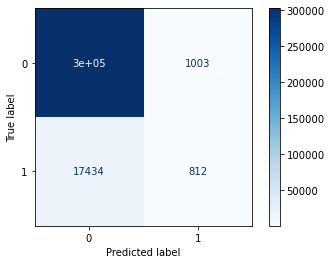

f1 : 0.0810
recall : 0.0445
negative predictive value : 0.9456
precision : 0.4474
roc_auc : 0.7333


In [4]:
m = Modelisation(X_quant, y, LogisticRegression(), scaling=True)
m.show_conf_matrix()
m.show_metrics_score()

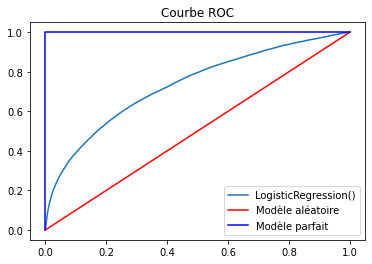

In [5]:
m.show_ROC()

In [6]:
coeff_df = pd.DataFrame(np.transpose(m.model.coef_), X_quant.columns, columns=['Coefficient'])
coeff_df

,Coefficient
contextid,-0.023383
campaignctrlast24h,0.364655
dayssincelastvisitdouble,-0.029170
ltf_nbglobaldisplay_4w,0.006001
ltf_nbpartnerdisplayssincelastclick,-0.024092
ltf_nbpartnerdisplay_90d,-0.007595
ltf_nbpartnerclick_90d,0.033988
ltf_nbpartnersales_90d,-0.010037
nbdayssincelastclick,-0.109592
nbdisplay_1hour,-0.222505


In [7]:
from statsmodels.discrete.discrete_model import Logit
from statsmodels.tools import add_constant

X_ = add_constant(X_quant)
print(Logit(y, X_).fit().summary())

Optimization terminated successfully.
         Current function value: 0.197126
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:     is_display_clicked   No. Observations:              1610494
Model:                          Logit   Df Residuals:                  1610480
Method:                           MLE   Df Model:                           13
Date:                Mon, 15 Feb 2021   Pseudo R-squ.:                 0.09804
Time:                        23:44:40   Log-Likelihood:            -3.1747e+05
converged:                       True   LL-Null:                   -3.5198e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
const                                   -3.7845      0.0

Avec LASSO (+ univariate mais variable déjà exclue par Lasso): 

In [8]:
X1 = df[['contextid',
         'zonecostineuro',
         'campaignctrlast24h',
         'ltf_nbpartnerclick_90d',
         'nbdisplay_1hour',
         'nbdayssincelastclick',
         'display_size',
         'nbdisplayglobalapprox_1d_sum_xdevice']]
y1 = df['is_display_clicked']

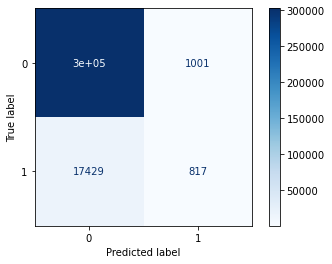

f1 : 0.0814
recall : 0.0448
negative predictive value : 0.9456
precision : 0.4494
roc_auc : 0.7332


In [9]:
m1 = Modelisation(X1, y1, LogisticRegression(), scaling=True)
m1.show_conf_matrix()
m1.show_metrics_score()

## Categorical variables

In [10]:
# Nombre de valeurs distinctes
for column in columns_cat:
    print(f"{column} : {len(set(df[column]))}")

display_env : 4
target_env : 2
campaignscenario : 7
campaignvertical : 34
is_interstitial : 3
device_type : 7
hour : 24
weekday : 7


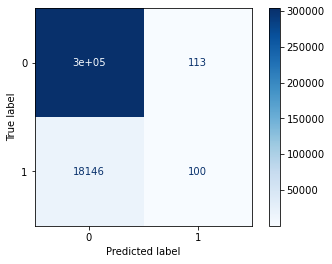

f1 : 0.0108
recall : 0.0055
negative predictive value : 0.9436
precision : 0.4695
roc_auc : 0.6816


In [11]:
m = Modelisation(X_cat, y, LogisticRegression(), scaling=True)
m.show_conf_matrix()
m.show_metrics_score()

## Quantitative + categorical

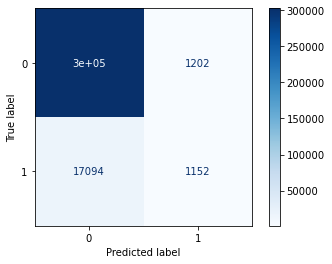

f1 : 0.1118
recall : 0.0631
negative predictive value : 0.9465
precision : 0.4894
roc_auc : 0.7521
Wall time: 10.5 s


In [12]:
%%time
m = Modelisation(X_quant_cat, y, LogisticRegression(), scaling=True)
m.show_conf_matrix()
m.show_metrics_score()

Avec RFECV :

In [13]:
X2 = X_quant_cat[['zonecostineuro',
         'campaignctrlast24h',
         'nbdisplay_1hour',
         'nbdayssincelastclick',
         'display_size',
         'is_interstitial_True',
         'device_type_Desktop',
         'device_type_iPhone',
         'display_env_app_ios',
         'target_env_2',
         'campaignscenario_13']]
y2 = df['is_display_clicked']

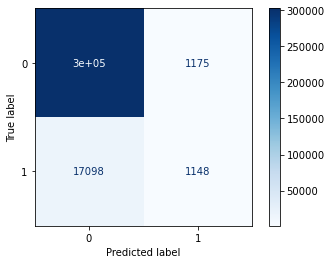

f1 : 0.1116
recall : 0.0629
negative predictive value : 0.9465
precision : 0.4942
roc_auc : 0.7487
Wall time: 3.3 s


In [14]:
%%time
m2 = Modelisation(X2, y2, LogisticRegression(), scaling=True)
m2.show_conf_matrix()
m2.show_metrics_score()

## Comparaison par rapport aux valeurs de C 

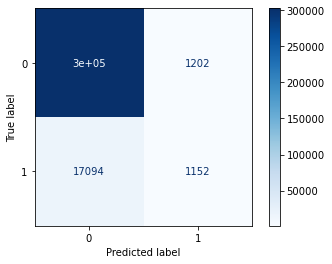

f1 : 0.1118
recall : 0.0631
negative predictive value : 0.9465
precision : 0.4894
roc_auc : 0.7521


In [15]:
m = Modelisation(X_quant_cat, y, LogisticRegression(C=0.2), scaling=True)
m.show_conf_matrix()
m.show_metrics_score()

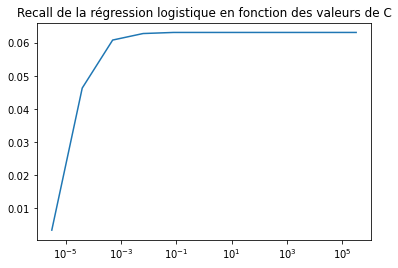

Wall time: 1min 56s


In [16]:
%%time
C, list_recall = [], []
for c in np.logspace(-5.5, 5.5, num=11): 
    m = Modelisation(X_quant_cat, y, LogisticRegression(C=c), scaling=True)
    C.append(c)
    list_recall.append(m.recall)
plt.plot(C, list_recall)
plt.xscale('log')
plt.title("Recall de la régression logistique en fonction des valeurs de C")
plt.show()

In [17]:
print(f"Temps d'exécution total : {time.strftime('%H:%M:%S', time.gmtime(time.time()-t))}")

Temps d'exécution total : 00:03:06
